In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

In [3]:
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancerous', 'non cancerous']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(224, 224))
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
folder_path = "/kaggle/input/oral-cancer-images/Oral_Cancer_Images"
images, labels = load_data(folder_path)
images = images / 255.0

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=32,
    shuffle=True
)

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5)

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)
model.save('ResNet50.keras')

Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 51s 165ms/step - accuracy: 0.5015 - loss: 0.7629 - precision: 0.4906 - recall: 0.4875 - val_accuracy: 0.5699 - val_loss: 0.6634 - val_precision: 0.9750 - val_recall: 0.1299 - learning_rate: 1.0000e-04
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.5746 - loss: 0.6806 - precision: 0.5570 - recall: 0.5395 - val_accuracy: 0.6951 - val_loss: 0.6281 - val_precision: 0.8465 - val_recall: 0.4650 - learning_rate: 1.0000e-04
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.6305 - loss: 0.6417 - precision: 0.6283 - recall: 0.5789 - val_accuracy: 0.5749 - val_loss: 0.6612 - val_precision: 0.9843 - val_recall: 0.1387 - learning_rate: 1.0000e-04
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - accuracy: 0.6391 - loss: 0.6341 - precision: 0.6537 - recall: 0.5792 - val_accuracy: 0.6940 - val_loss: 0.5969 - val_precision: 0.8635 - val_recall: 0.4495 - learning_rate: 1.0000e-04
Epoch 5/50
229/229 ━━━━━━━━━━━━━━━━━

58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step


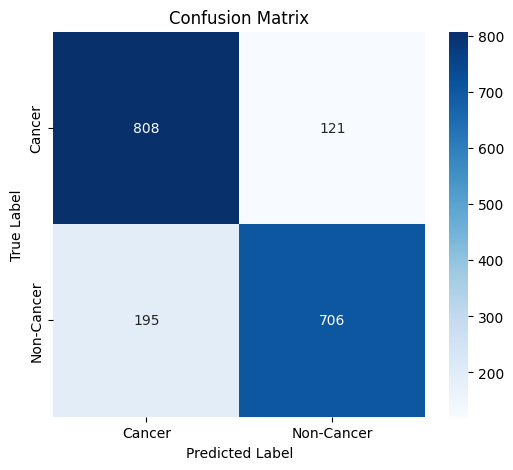

In [12]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cancer", "Non-Cancer"], yticklabels=["Cancer", "Non-Cancer"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()